# Tutorial for anomaly detection (DNN feature matrix) 

We use the FastDVDNet model to extract suitable features for anomaly detection [[1](https://openaccess.thecvf.com/content_CVPR_2020/html/Tassano_FastDVDnet_Towards_Real-Time_Deep_Video_Denoising_Without_Flow_Estimation_CVPR_2020_paper.html)]. The outcome
is a predicted frame that is subtracted from the target frame to construct a feature map that is
used to create the feature matrix (see [Creating handcrafted feature matrix](Tutorial_anomaly_1.ipynb#Creating-hand-crafted-feature-matrix)).


## Previously on PiSCAT tutorials...
<span style="color:red">Please install PiSCAT Plugins ``UAI`` ([link](https://piscat.readthedocs.io/installation.html#adding-piscat-plugins)) before running this tutorial!</span>.


We assume the user is familiar with [PiSCAT](https://piscat.readthedocs.io/). In particular, we have previously demonstrated how
to use PiSCAT’s APIs for setting up the PiSCAT modules and downloading a demo iSCAT video,
performing basic checks on the acquisition process and basic data visualization and how one can
use [DRA](https://piscat.readthedocs.io/Tutorial2/Tutorial2.html#frame-averaging-to-boost-snr-of-imaged-proteins-followed-by-visualization-of-their-signal-via-differential-imaging) and [FPN](https://piscat.readthedocs.io/Tutorial3/Tutorial3.html#tutorial-for-the-correction-of-the-fixed-pattern-noise-in-iscat-images-recorded-using-a-scmos-camera) for backgorund correction. We have also demonstrated how to reduce the hot
pixel effects. Based on the number of available CPU cores for parallel processing, this tutorial needs
12-30 GB of computer memory (RAM) to run. We also use tensor flow, which can utilize GPU for
improving the performance of the DNN training/testing.

In [1]:
# Only to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Setting up the path to the PiSCAT modules
import os
import sys
current_path = os.path.abspath(os.path.join('..'))
dir_path = os.path.dirname(current_path)
module_path = os.path.join(dir_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Downloading a measurement video for this tutorial 
from piscat.InputOutput import download_tutorial_data
download_tutorial_data('Tutorial_UAI')
     
# Examining the status line in a loaded/downloaded video and removing the line
from piscat.InputOutput import reading_videos
from piscat.Visualization import JupyterDisplay,JupyterSubplotDisplay 
from piscat.InputOutput import read_status_line
from piscat.Preproccessing import normalization
from piscat.BackgroundCorrection import DifferentialRollingAverage
import numpy as np

data_path = os.path.join(dir_path, 'Tutorials', 'Demo data', 'UAI', '9KDa')#The path to the measurement data
df_video = reading_videos.DirectoryType(data_path, type_file='bin').return_df()
paths = df_video['Directory'].tolist()
video_names = df_video['File'].tolist()
demo_video_path = os.path.join(paths[0], video_names[0])#Selecting the first entry in the list
video_ = reading_videos.video_reader(file_name=demo_video_path, type='binary', img_width=72, img_height=72, 
                                    image_type=np.dtype('<u2'), s_frame=0, e_frame=-1)#Loading the video

video = video_[1000:90000, ...]# Trimming the data and setting it to where iSCAT measurement is started.

status_ = read_status_line.StatusLine(video)#Reading the status line
video_remove_status, status_information  = status_.find_status_line()#Examining the status line & removing it

#From previous tutorials: power normalization, FPNc, DRA
video_pn, _ = normalization.Normalization(video=video_remove_status).power_normalized()
batchSize = 7000
DRA_PN = DifferentialRollingAverage(video=video_pn, batchSize=batchSize, mode_FPN='mFPN')
RVideo_PN_FPN_, _ = DRA_PN.differential_rolling(FFT_flag=False, FPN_flag=True, select_correction_axis='Both')


 
from piscat.Preproccessing import filtering

# Hot Pixels correction
video_pn_hotPixel = filtering.Filters(video_pn, inter_flag_parallel_active=False).median(3)

RVideo_PN_FPN_hotPixel = filtering.Filters(RVideo_PN_FPN_, inter_flag_parallel_active=False).median(3)

from piscat.Visualization.display_jupyter import JupyterSubplotDisplay
# For Jupyter notebooks only:
%matplotlib inline

# Display 
list_titles = ['Filter hot pixel (raw iSCAT video)', 'Filter hot pixel (DRA video)']
JupyterSubplotDisplay(list_videos=[video_pn_hotPixel, RVideo_PN_FPN_hotPixel], 
                        numRows=1, numColumns=2, list_titles=list_titles, 
                        imgSizex=10, imgSizey=5, IntSlider_width='500px',
                        median_filter_flag=False, color='gray', value=40909)


Directory  F:\PiSCAT_GitHub_public\PiSCAT\Tutorials  already exists

The directory with the name  Demo data  already exists in the following path: F:\PiSCAT_GitHub_public\PiSCAT\Tutorials

The data file named  UAI  already exists in the following path: F:\PiSCAT_GitHub_public\PiSCAT\Tutorials\Demo data
---Status line detected in column---

start power_normalized without parallel loop---> Done

--- start DRA + mFPN_axis: Both---


  0%|          | 0/74999 [00:00<?, ?it/s]


median FPN correction without parallel loop ---> 

  0%|          | 0/75000 [00:00<?, ?it/s]

Done

median FPN correction without parallel loop ---> 

  0%|          | 0/75000 [00:00<?, ?it/s]

Done

---start median filter without Parallel---

---start median filter without Parallel---


interactive(children=(IntSlider(value=40909, continuous_update=False, description='Frame:', layout=Layout(widt…

## Training
<font color='red'> Since the training process is time-consuming, especially on the CPU, and requires fine-tuning, we share pre-trained weights. Thus, you can skip to the [Testing](http://localhost:8888/notebooks/Tutorial_Files/Tutorial_anomaly_2.ipynb#Testing) stage.</font>

As a first step for training the fastdvdnet, the data needs to be normalized. This is done by using `normalized_image_global`, which renders a video with values between zero and one. FatDVDNet requires the data of the following shape: (#batches, image width, image height, #frame (always 5)),
which can be created by using the `data_handling` function. The output of this class can then be fed
into a tarining model.


In [8]:
from piscat.Preproccessing.normalization import Normalization

# Normalization
train_video = RVideo_PN_FPN_hotPixel[30000:50000:1]
video_norm = Normalization(train_video).normalized_image_global()

# Training
from piscat.Plugins.UAI.DNNModel.FastDVDNet import FastDVDNet

dnn_ = FastDVDNet(video_original=video_norm)
batch_original_array, _ = dnn_.data_handling(stride=50)


save_DNN_path = os.path.join(dir_path, 'Tutorials', 'Demo data')#The path to the measurement data


hyperparameters = {'DNN_batch_size':20, 'epochs': 100, 'shuffle': False, 'validation_split': 0.33}
dnn_.train(video_input_array=batch_original_array,
           DNN_param=hyperparameters,
           video_label_array=None,
           path_save=save_DNN_path, name_weights="anomaly_weights_new.h5", flag_warm_train=False)

--- model tarin on CPU---!
Epoch 1/100
 49/662 [=>............................] - ETA: 35:08 - loss: 0.0644

KeyboardInterrupt: 

## Testing

Results of DNN can be seen here. Due to artifacts that occur around edges and corners, we use the
`Mask2Video` class to apply a circular mask on the video.

In [2]:
save_DNN_path = os.path.join(dir_path, 'Tutorials', 'Demo data', 'UAI')#The path to the measurement data


from piscat.Preproccessing.normalization import Normalization

# Normalization
test_video = RVideo_PN_FPN_hotPixel[30000:50000:1]
video_norm = Normalization(test_video).normalized_image_global()

# Training
from piscat.Plugins.UAI.DNNModel.FastDVDNet import FastDVDNet

dnn_ = FastDVDNet(video_original=video_norm)
batch_original_array, cropped_video = dnn_.data_handling(stride=1)


feature_DNN = dnn_.test(video_input_array=batch_original_array, path_save=save_DNN_path, 
          name_weights="anomaly_weights.h5")

from piscat.Preproccessing.applying_mask import Mask2Video

diff_vid = np.abs(cropped_video[2:-2, ...] - feature_DNN)
M2Vid = Mask2Video(diff_vid, mask=None, inter_flag_parallel_active=False)
circlur_mask = M2Vid.mask_generating_circle(center=(int(diff_vid.shape[1]/2), int(diff_vid.shape[2]/2)), 
                                            redius=30)
video_mask = M2Vid.apply_mask(flag_nan=False)

# Display 
list_titles = ['DNN_output', 'probability map', 'masked probability map']
JupyterSubplotDisplay(list_videos=[feature_DNN, diff_vid, video_mask], 
                        numRows=1, numColumns=3, list_titles=list_titles, 
                        imgSizex=20, imgSizey=20, IntSlider_width='500px',
                        median_filter_flag=True, color='gray', value=17681)

---Loaded model weights from disk!---
--- model test on CPU---!
625/625 [==============================] - 673s 1s/step
--- Mask is not define! ---

---apply mask without Parallel---


  0%|          | 0/19996 [00:00<?, ?it/s]

  0%|          | 0/19996 [00:00<?, ?it/s]

interactive(children=(IntSlider(value=17681, continuous_update=False, description='Frame:', layout=Layout(widt…

In [3]:
from piscat.Plugins.UAI.Anomaly.hand_crafted_feature_genration import CreateFeatures

feature_maps_spatio = CreateFeatures(video=cropped_video[2:-2, ...])
dog_features = feature_maps_spatio.dog2D_creater(low_sigma=[1.7, 1.7], high_sigma=[1.8, 1.8], internal_parallel_flag=False)


from piscat.Plugins.UAI.Anomaly.DNN_anomaly import DNNAnomaly

if_dnn = DNNAnomaly([video_mask, dog_features], contamination=0.002)
mask_video_ = if_dnn.apply_IF_spacial_temporal(step=10, stride=200)


from piscat.Preproccessing.normalization import Normalization

r_diff = int(0.5 * abs(mask_video_.shape[1] - video_norm.shape[1]))
c_diff = int(0.5 * abs(mask_video_.shape[2] - video_norm.shape[2]))

mask_video_pad = np.pad(mask_video_, ((0, 0), (r_diff, r_diff), (c_diff, c_diff)), 'constant', constant_values=((0, 0), (1, 1), (1, 1)))

result_anomaly_ = mask_video_pad.copy()
result_anomaly_[mask_video_pad == -1] = 0
result_anomaly_ = Normalization(video=result_anomaly_.astype(int)).normalized_image_specific()

# Display 
JupyterSubplotDisplay(list_videos=[video_norm, result_anomaly_], 
                                    numRows=1, numColumns=2, list_titles=['DRA', 'Anomaly'], 
                                    imgSizex=10, imgSizey=10, IntSlider_width='500px',
                                    median_filter_flag=False, color='gray', value=17681)


---start DOG feature without parallel loop---


  0%|          | 0/19996 [00:00<?, ?it/s]


---start anomaly with Parallel---


  0%|          | 0/19996 [00:00<?, ?it/s]


converting video bin_type to uint8---> Done


interactive(children=(IntSlider(value=17681, continuous_update=False, description='Frame:', layout=Layout(widt…

## Localization

The results of anomaly detection generate a binary video with zero values for the pixels that have
been identified as anomalous. The number of connected pixels in a certain region indicates the
likelihood that this region contains an actual iPSF. The `BinaryToiSCATLocalization` class employs
[morphological operations](https://scikit-image.org/docs/stable/api/skimage.morphology.html#area-closing) to eliminate low probability pixels and to determine the center of mass
for each highlighted area. Previous localization methods (e.g., DOG, 2D-Gaussian fit, and radial
symmetry) can now be utilized to fine tune localization with sub-pixel accuracy in the window
around each center of mass.

In [4]:
from piscat.Plugins.UAI.Anomaly.anomaly_localization import BinaryToiSCATLocalization

binery_localization = BinaryToiSCATLocalization(video_binary=result_anomaly_, sigma=1.7, 
                                                video_iSCAT=test_video, 
                                                area_threshold=3, internal_parallel_flag=False)

df_PSFs = binery_localization.gaussian2D_fit_iSCAT(scale=1, internal_parallel_flag=False)
df_PSFs.info()


---start area closing without Parallel---


  0%|          | 0/19996 [00:00<?, ?it/s]


---start gaussian filter without Parallel---

---start area local_minima without Parallel---


  0%|          | 0/19996 [00:00<?, ?it/s]


---Cleaning the df_PSFs that have side lobs without parallel loop---


  0%|          | 0/10680 [00:00<?, ?it/s]


Number of PSFs before filters = 16813

Number of PSFs after filters = 12071

---Fitting 2D gaussian without parallel loop---


  0%|          | 0/12071 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12071 entries, 0 to 12070
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   y                     12071 non-null  float64
 1   x                     12071 non-null  float64
 2   frame                 12071 non-null  float64
 3   center_intensity      9952 non-null   float64
 4   sigma                 12071 non-null  float64
 5   Sigma_ratio           12071 non-null  float64
 6   Fit_Amplitude         11612 non-null  float64
 7   Fit_X-Center          11612 non-null  float64
 8   Fit_Y-Center          11612 non-null  float64
 9   Fit_X-Sigma           11612 non-null  float64
 10  Fit_Y-Sigma           11612 non-null  float64
 11  Fit_Bias              11612 non-null  float64
 12  Fit_errors_Amplitude  11612 non-null  float64
 13  Fit_errors_X-Center   11612 non-null  float64
 14  Fit_errors_Y-Center   11612 non-null  float64
 15  Fit_errors_X-Sigma 

In [5]:
# Localization Display
from piscat.Visualization import JupyterPSFs_subplotLocalizationDisplay
JupyterPSFs_subplotLocalizationDisplay(list_videos=[test_video, binery_localization.blure_video], 
                                       list_df_PSFs=[df_PSFs, df_PSFs], 
                                        numRows=1, numColumns=2, 
                                        list_titles=['DRA localization', 'Anomaly Mask'], 
                                        median_filter_flag=False, color='gray', imgSizex=10, imgSizey=10, 
                                        IntSlider_width='400px', step=1, value=17681)

interactive(children=(IntSlider(value=17681, continuous_update=False, description='Frame:', layout=Layout(widt…

## loading TIRF

To check the validity of the localization, the corresponding frames of the TIRF measurement are loaded.


In [6]:
data_path_Flo = os.path.join(dir_path, 'Tutorials', 'Demo data', 'UAI', 'TIRF')#The path to the measurement data
df_video_Flo = reading_videos.DirectoryType(data_path_Flo, type_file='raw').return_df()
paths_Flo = df_video_Flo['Directory'].tolist()
video_names_Flo = df_video_Flo['File'].tolist()
demo_video_path_Flo = os.path.join(paths_Flo[0], video_names_Flo[0])#Selecting the first entry in the list
video_Flo = reading_videos.video_reader(file_name=demo_video_path_Flo, type='binary', img_width=72, img_height=72, 
                                    image_type=np.dtype('<f8'), s_frame=0, e_frame=-1)#Loading the video

from piscat.Preproccessing import filtering

# Hot Pixels correction
video_flo_hotPixel_ = filtering.Filters(video_Flo, inter_flag_parallel_active=False).median(3)
video_flo_hotPixel = filtering.Filters(video_flo_hotPixel_, inter_flag_parallel_active=False).gaussian(1.8)


JupyterSubplotDisplay(list_videos=[video_flo_hotPixel], 
                    numRows=1, numColumns=1, list_titles=['TIRF'], imgSizex=5, imgSizey=5, IntSlider_width='500px',
                    median_filter_flag=False, color='hot', value=14, vmin=-0.05, vmax=0.03)



---start median filter without Parallel---

---start gaussian filter without Parallel---


interactive(children=(IntSlider(value=14, continuous_update=False, description='Frame:', layout=Layout(width='…

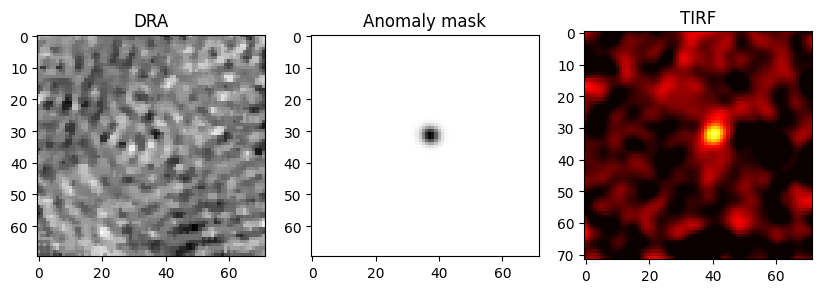

In [7]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
ax1.imshow(test_video[17423], cmap='gray')
ax2.imshow(binery_localization.blure_video[17423], cmap='gray')
ax3.imshow(video_flo_hotPixel[14], cmap='hot', vmin=-0.05, vmax=0.03)
ax1.title.set_text('DRA')
ax2.title.set_text('Anomaly mask')
ax3.title.set_text('TIRF')
plt.show()

### Bibliography
1. [Tassano, Matias, Julie Delon, and Thomas Veit. "Fastdvdnet: Towards real-time deep video denoising without flow estimation." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2020.](https://openaccess.thecvf.com/content_CVPR_2020/html/Tassano_FastDVDnet_Towards_Real-Time_Deep_Video_Denoising_Without_Flow_Estimation_CVPR_2020_paper.html)